# KNN Model
**Michael Maldonado**

### Importing Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, plot_roc_curve, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import talib as ta

# If talib is not installed, uncomment and run
# !pip install talib-binary

In [30]:
# All plots will have a default DPI of 200
plt.rcParams['figure.dpi'] = 200

### Loading data into dataframe

In [31]:
data = pd.read_csv("Data/ETFs/qqq.us.txt", delimiter = ",")
data = data.drop(columns = ["OpenInt"])
data["Date"] = pd.to_datetime(data["Date"])
data = data.set_index("Date")

data.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
1999-03-10,45.722,45.750,44.967,45.665,11700414
1999-03-11,45.994,46.260,44.988,45.880,21670048
1999-03-12,45.721,45.749,44.406,44.770,19553768
1999-03-15,45.101,46.103,44.625,46.052,14245348
1999-03-16,46.253,46.643,45.749,46.447,10971066


Text(0.5, 1.0, 'NASDAQ: QQQ')

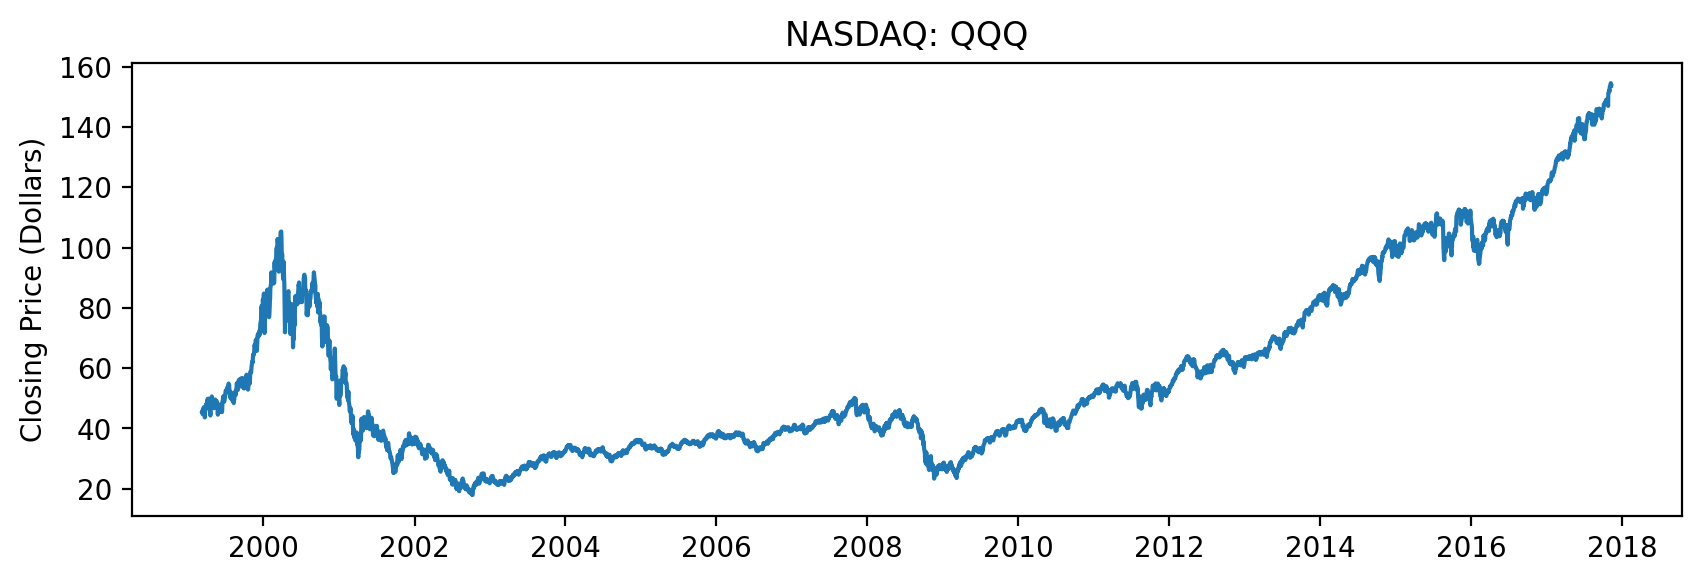

In [32]:
fig = plt.figure(dpi = 200, figsize= (10, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(data["Close"])
ax.set_ylabel("Closing Price (Dollars)")
ax.set_title("NASDAQ: QQQ")

### Adding indicators to dataset

In [33]:
# RSI
data["RSI"] = ta.RSI(data["Close"].to_numpy())

# Stochastic Oscillator Slow
data["STOCH"] = ta.STOCH(data["High"].to_numpy(), 
                          data["Low"].to_numpy(), 
                          data["Close"].to_numpy())[0]

# Williams Percent Range
data["WILLR"] = ta.WILLR(data["High"].to_numpy(), 
                          data["Low"].to_numpy(), 
                          data["Close"].to_numpy())

# Moving Average Convergence/Divergence
data["MACD"] = ta.MACD(data["Close"].to_numpy())[0]

# Price Rate of Change
data["PROC"] = data['Close'].transform(lambda x: x.pct_change(periods = 9))

# On Balance Volume
data["OBV"] = ta.OBV(data["Close"].to_numpy(), data["Volume"].to_numpy(np.double))

# Average Directional Movement Index
data["ADX"] = ta.ADX(data["High"].to_numpy(), 
                     data["Low"].to_numpy(), 
                     data["Close"].to_numpy())

# Aroon Oscillator
data["AROON"] = ta.AROONOSC(data["High"].to_numpy(), data["Low"].to_numpy())

# Money Flow Index
data["MFI"] = ta.MFI(data["High"].to_numpy(), 
                     data["Low"].to_numpy(), 
                     data["Close"].to_numpy(), 
                     data["Volume"].to_numpy(np.double))

# Commodity Channel Index
data["CCI"] = ta.CCI(data["High"].to_numpy(), 
                     data["Low"].to_numpy(), 
                     data["Close"].to_numpy())

data.head(5)

,Open,High,Low,Close,Volume,RSI,STOCH,WILLR,MACD,PROC,OBV,ADX,AROON,MFI,CCI
Date,,,,,,,,,,,,,,,
1999-03-10,45.722,45.750,44.967,45.665,11700414,NaN,NaN,NaN,NaN,NaN,11700414.0,NaN,NaN,NaN,NaN
1999-03-11,45.994,46.260,44.988,45.880,21670048,NaN,NaN,NaN,NaN,NaN,33370462.0,NaN,NaN,NaN,NaN
1999-03-12,45.721,45.749,44.406,44.770,19553768,NaN,NaN,NaN,NaN,NaN,13816694.0,NaN,NaN,NaN,NaN
1999-03-15,45.101,46.103,44.625,46.052,14245348,NaN,NaN,NaN,NaN,NaN,28062042.0,NaN,NaN,NaN,NaN
1999-03-16,46.253,46.643,45.749,46.447,10971066,NaN,NaN,NaN,NaN,NaN,39033108.0,NaN,NaN,NaN,NaN


### Cleaning dataset

In [34]:
# Creating column for prediction
data["Prediction"] = data["Close"].transform(lambda x: (x.shift(1) < x) * 1)

# Dropping NaN values
print(f"Before NaN Drop: ROW:{data.shape[0]}, COL:{data.shape[1]}")
data = data.dropna()
print(f"After NaN Drop: ROW:{data.shape[0]}, COL:{data.shape[1]}")

features = data[["RSI", "STOCH", "WILLR", "MACD", "PROC", "OBV", "ADX", "AROON", "MFI", "CCI"]]

data.head(5)

Before NaN Drop: ROW:4701, COL:16
After NaN Drop: ROW:4668, COL:16


,Open,High,Low,Close,Volume,RSI,STOCH,WILLR,MACD,PROC,OBV,ADX,AROON,MFI,CCI,Prediction
Date,,,,,,,,,,,,,,,,
1999-04-27,50.973,51.224,49.195,49.830,36863308,57.811022,88.722097,-18.475812,0.920327,0.055050,-10969163.0,20.127568,35.714286,23.694120,87.151254,0
1999-04-28,49.413,49.575,47.908,48.121,17167936,51.259834,61.637865,-41.126574,0.819158,0.005264,-28137099.0,18.826879,35.714286,23.745454,19.767615,0
1999-04-29,47.893,48.173,46.721,47.726,42827866,49.853638,37.439706,-46.361829,0.699050,0.026918,-70964965.0,18.296637,35.714286,19.378555,-20.171528,0
1999-04-30,48.402,48.652,46.331,48.040,34208333,51.004290,23.336489,-42.200133,0.622030,0.084694,-36756632.0,17.483322,35.714286,26.715877,-8.073420,1
1999-05-03,47.896,48.090,46.984,47.782,24847266,49.989312,28.966837,-45.619616,0.534017,0.054883,-61603898.0,16.728100,35.714286,26.604431,-5.719418,0


### Splitting dataset and Training model

#### KNN Regressor, Randomized Test/Train Split (Before Scaling)

In [66]:
# Split into training and testing datasets
x_trainr, x_testr, y_trainr, y_testr = train_test_split(features, data["Close"], random_state = 0)

# Create a Random Forest Classifier
regressor = KNeighborsRegressor(n_neighbors = 4)

# Fit the data to the model
regressor.fit(x_trainr, y_trainr)

# Make predictions
y_predr = regressor.predict(x_testr)

print(f"Regressor R2 (%): {r2_score(y_testr, y_predr)}")
print(f"Regressor MSE (%): {mean_squared_error(y_testr, y_predr)}")

Regressor R2 (%): 0.5820619332240511
Regressor MSE (%): 411.5735299288774


#### KNN Regressor, Randomized Test/Train Split (After Scaling)

In [36]:
# Scaling Features
scaler = StandardScaler()
scaler.fit(features)

features_scaled = pd.DataFrame(scaler.transform(features), columns = features.columns)
features_scaled.head(5)

,RSI,STOCH,WILLR,MACD,PROC,OBV,ADX,AROON,MFI,CCI
0,0.332638,1.201009,0.712019,0.773018,1.087600,-1.589719,-0.418347,0.33016,-1.693829,0.667683
1,-0.219560,0.180499,-0.005424,0.671064,0.039291,-1.596232,-0.569996,0.33016,-1.690759,0.032711
2,-0.338088,-0.731266,-0.171246,0.550024,0.495236,-1.612479,-0.631818,0.33016,-1.951896,-0.343645
3,-0.241100,-1.262662,-0.039428,0.472406,1.711800,-1.599502,-0.726643,0.33016,-1.513130,-0.229642
4,-0.326652,-1.050516,-0.147737,0.383710,1.084098,-1.608927,-0.814695,0.33016,-1.519794,-0.207459


In [69]:
# Split into training and testing datasets
x_trainr_s, x_testr_s, y_trainr_s, y_testr_s = train_test_split(features_scaled, 
                                                                data["Close"], 
                                                                random_state = 0)

# Create a Random Forest Classifier
regressor = KNeighborsRegressor(n_neighbors = 5)

# Fit the data to the model
regressor.fit(x_trainr_s, y_trainr_s)

# Make predictions
y_predr_s = regressor.predict(x_testr_s)

print(f"Regressor Scaled R2 (%): {r2_score(y_testr_s, y_predr_s)}")
print(f"Regressor Scaled MSE (%): {mean_squared_error(y_testr_s, y_predr_s)}")

Regressor Scaled R2 (%): 0.6854657216748614
Regressor Scaled MSE (%): 309.7444179051243


### Plotting regressor predicted prices

#### KNN Regressor, Randomized Test/Train Split (Before Scaling)

Text(0.5, 1.0, 'KNN Regressor, Randomized Test/Train Split (Before Scaling)')

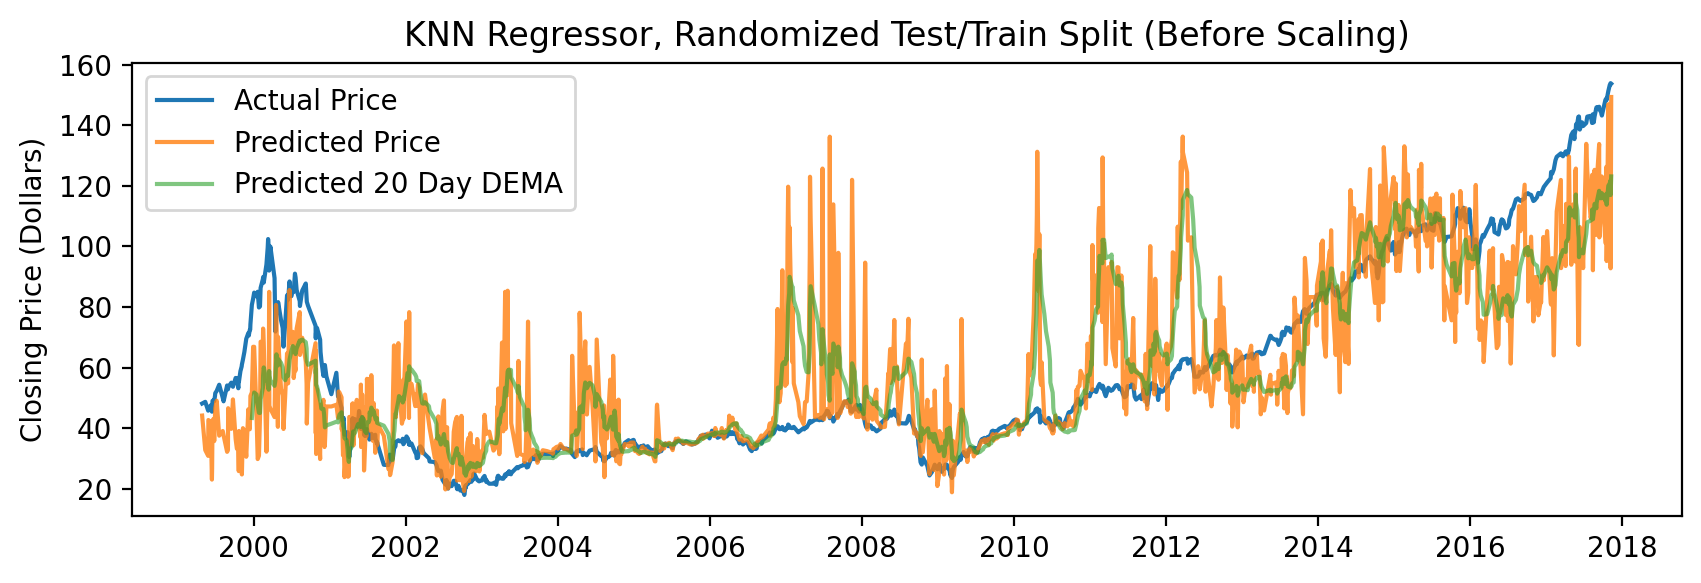

In [74]:
predicted = pd.Series(data = y_predr, index = y_testr.index)
predicted = predicted.sort_index()

# Double Exponential Moving Average of Predicted Prices
predicted_SMA = ta.DEMA(predicted, timeperiod = 20)

actual = y_testr.sort_index()

fig = plt.figure(dpi = 200, figsize = (10, 3))
ax = fig.add_subplot(1, 1, 1)
actual_line = ax.plot(actual, label = "Actual Price")
predicted_line = ax.plot(predicted, label = "Predicted Price", alpha = 0.8)
SMA_line = ax.plot(predicted_SMA, label = "Predicted 20 Day DEMA", alpha = 0.6)
ax.set_ylabel("Closing Price (Dollars)")
ax.legend()
ax.set_title("KNN Regressor, Randomized Test/Train Split (Before Scaling)")

#### KNN Regressor, Randomized Test/Train Split (After Scaling)

Text(0.5, 1.0, 'KNN Regressor, Randomized Test/Train Split (After Scaling)')

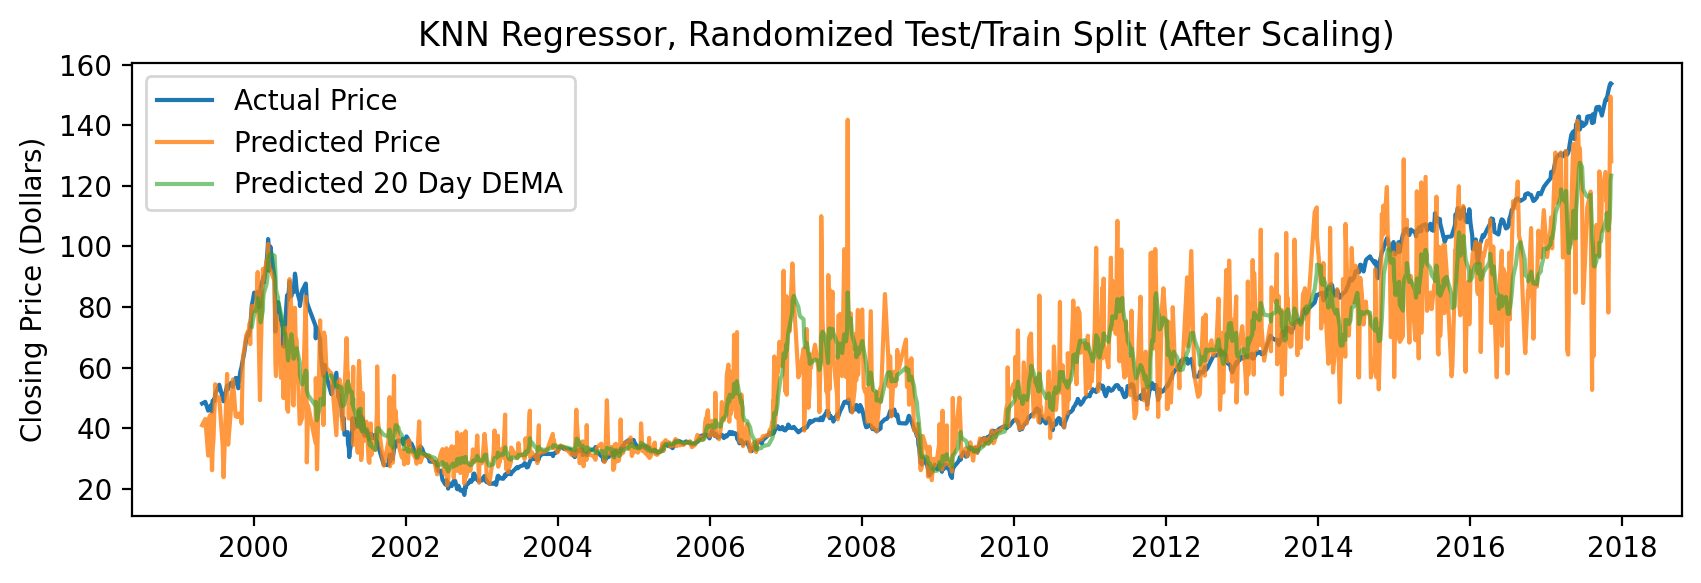

In [72]:
predicted_scaled = pd.Series(data = y_predr_s, index = y_testr.index)
predicted_scaled = predicted_scaled.sort_index()

# Double Exponential Moving Average of Predicted Prices
predicted_scaled_SMA = ta.DEMA(predicted_scaled, timeperiod = 20)

actual = y_testr_s.sort_index()

fig = plt.figure(dpi = 200, figsize = (10, 3))
ax = fig.add_subplot(1, 1, 1)
actual_line = ax.plot(actual, label = "Actual Price")
predicted_scaled_line = ax.plot(predicted_scaled, label = "Predicted Price", alpha = 0.8)
SMA_scaled_line = ax.plot(predicted_scaled_SMA, label = "Predicted 20 Day DEMA", alpha = 0.6)
ax.set_ylabel("Closing Price (Dollars)")
ax.legend()
ax.set_title("KNN Regressor, Randomized Test/Train Split (After Scaling)")